# Exemplo de Uso – Vassoura 

Este notebook mostra como utilizar as principais funcionalidades do pacote `vassoura` para detectar e limpar multicolinearidade, além de gerar relatórios visuais.

In [1]:
import numpy as np
import pandas as pd
import vassoura as vs
import matplotlib.pyplot as plt
import seaborn as sns

## Criando um DataFrame de exemplo para Análise de AutoCorrelação

In [2]:
def criar_dataset_pd_behavior(
    n_clientes: int = 1200,
    anos: int = 3,
    n_features: int = 20,
    seed: int = 42
) -> pd.DataFrame:
    """
    Gera um dataset sintético para modelagem de PD behavior com múltiplos contratos e série temporal mensal.

    Parâmetros:
    -----------
    n_clientes : int
        Número de contratos únicos (IDs) a serem simulados.
    anos : int
        Número de anos de dados mensais (série temporal).
    n_features : int
        Quantidade de variáveis preditoras (features) sintéticas.
    seed : int
        Semente para reprodutibilidade.

    Retorna:
    --------
    pd.DataFrame
        DataFrame com colunas: NroContrato, AnoMesReferencia, features, ever90m12
    """
    np.random.seed(seed)
    meses = anos * 12
    base_ano_mes = pd.date_range(start="2020-01-01", periods=meses, freq="MS").strftime("%Y%m").astype(int)

    # IDs dos contratos
    contratos = [f"C{i:05d}" for i in range(n_clientes)]

    # Produto cartesiano: contratos × meses
    df = pd.DataFrame([(c, m) for c in contratos for m in base_ano_mes], columns=["NroContrato", "AnoMesReferencia"])

    # Criar features sintéticas com padrão temporal + variabilidade individual
    for i in range(1, n_features + 1):
        ruido_individual = np.random.normal(0, 1, size=n_clientes).repeat(meses)
        sazonalidade = np.sin(np.linspace(0, 3 * np.pi, meses)).repeat(n_clientes)
        ruido_temporal = np.random.normal(0, 0.5, size=len(df))
        df[f"feature_{i:02d}"] = ruido_individual + sazonalidade + ruido_temporal

    # Simular target ever90m12 com base em algumas features e ruído
    logits = (
        0.3 * df["feature_01"] +
        0.2 * df["feature_02"] -
        0.4 * df["feature_03"] +
        np.random.normal(0, 1, size=len(df))
    )
    probs = 1 / (1 + np.exp(-logits))
    df["ever90m12"] = (probs > 0.8).astype(int)

    return df

df = criar_dataset_pd_behavior()

display(df.head(3))

,NroContrato,AnoMesReferencia,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,ever90m12
0,C00000,202001,0.559326,0.387383,-0.299318,0.425824,2.323016,-1.638147,-1.956999,0.663896,...,0.155365,0.539863,0.049552,-1.363366,1.862912,0.482685,0.642988,1.501705,0.935819,0
1,C00000,202002,0.282011,0.748080,-0.964748,0.054603,1.552315,-1.642361,-2.462300,0.346583,...,-0.120049,0.088565,0.009061,-2.131871,2.272921,1.009709,-0.237455,0.858004,-0.048012,0
2,C00000,202003,0.557863,1.288653,-1.069556,0.418011,1.482005,-2.221788,-2.930548,0.385271,...,0.857763,-1.055446,1.093087,-1.160692,2.629042,0.157022,0.068525,1.206976,-0.079348,0


## Detectando e limpando multicolinearidade

In [3]:
df_limpo, removidas, matriz_corr, vif_df = vs.clean(
    df,
    target_col='target',
    include_target=False,
    keep_cols=['x1'],
    corr_threshold=0.9,
    vif_threshold=10,
    verbose=True
)

INFO | NroContrato ignorada (muitas categorias: 1200)
INFO | AnoMesReferencia -> numérica
INFO | feature_01 -> numérica
INFO | feature_02 -> numérica
INFO | feature_03 -> numérica
INFO | feature_04 -> numérica
INFO | feature_05 -> numérica
INFO | feature_06 -> numérica
INFO | feature_07 -> numérica
INFO | feature_08 -> numérica
INFO | feature_09 -> numérica
INFO | feature_10 -> numérica
INFO | feature_11 -> numérica
INFO | feature_12 -> numérica
INFO | feature_13 -> numérica
INFO | feature_14 -> numérica
INFO | feature_15 -> numérica
INFO | feature_16 -> numérica
INFO | feature_17 -> numérica
INFO | feature_18 -> numérica
INFO | feature_19 -> numérica
INFO | feature_20 -> numérica
INFO | ever90m12 -> numérica
INFO | Método de correlação sugerido: pearson
INFO | Matriz de correlação pearson calculada para 22 variáveis numéricas
INFO | Encontrados 0 pares com |corr| > 0.90
INFO | NroContrato ignorada (muitas categorias: 1200)
INFO | AnoMesReferencia -> numérica
INFO | feature_01 -> numér

In [4]:
print('Variáveis removidas:', removidas)

Variáveis removidas: []


## Visualizando VIF das variáveis remanescentes

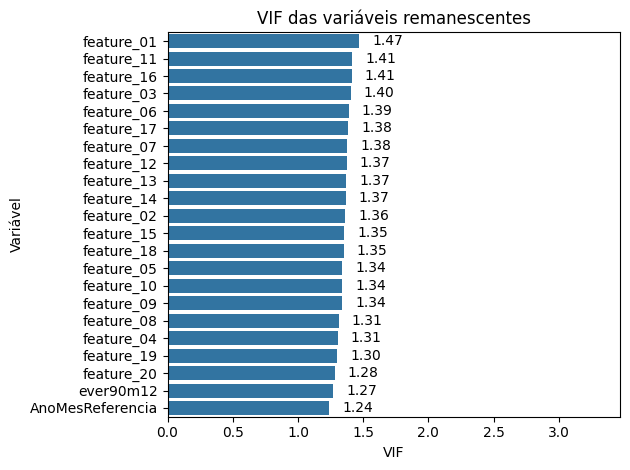

In [5]:
sns.barplot(data=vif_df, y='variable', x='vif', orient='h')
plt.title('VIF das variáveis remanescentes')
for i, row in vif_df.iterrows():
    plt.text(row['vif'] + 0.1, i, f"{row['vif']:.2f}", va='center')
plt.xlabel('VIF')
plt.ylabel('Variável')
plt.xlim(0, max(vif_df['vif']) + 2)
plt.tight_layout()
plt.show()

## Geração de relatório com gráficos e análise com/sem target
O relatório indicará automaticamente o método de correlação aplicado.

In [6]:
vs.generate_report(
    df,
    target_col='ever90m12',
    output_path='vassoura_report.html',
    corr_method='spearman'
)

INFO | NroContrato ignorada (muitas categorias: 1200)
INFO | AnoMesReferencia -> numérica
INFO | feature_01 -> numérica
INFO | feature_02 -> numérica
INFO | feature_03 -> numérica
INFO | feature_04 -> numérica
INFO | feature_05 -> numérica
INFO | feature_06 -> numérica
INFO | feature_07 -> numérica
INFO | feature_08 -> numérica
INFO | feature_09 -> numérica
INFO | feature_10 -> numérica
INFO | feature_11 -> numérica
INFO | feature_12 -> numérica
INFO | feature_13 -> numérica
INFO | feature_14 -> numérica
INFO | feature_15 -> numérica
INFO | feature_16 -> numérica
INFO | feature_17 -> numérica
INFO | feature_18 -> numérica
INFO | feature_19 -> numérica
INFO | feature_20 -> numérica
INFO | NroContrato ignorada (muitas categorias: 1200)
INFO | AnoMesReferencia -> numérica
INFO | feature_01 -> numérica
INFO | feature_02 -> numérica
INFO | feature_03 -> numérica
INFO | feature_04 -> numérica
INFO | feature_05 -> numérica
INFO | feature_06 -> numérica
INFO | feature_07 -> numérica
INFO | fea

'vassoura_report.html'

Abra o arquivo `vassoura_report.html` para visualizar o relatório gerado com:
- Tipos de variáveis
- Matrizes de correlação (com e sem target)
- VIF (em tabela e gráfico)
- Método de correlação aplicado

## Análise de AutoCorrelação

In [7]:
# Calcular autocorrelação por contrato e agregar por média
panel_acf = vs.compute_panel_acf(
    df,
    value_col="feature_01",
    time_col="AnoMesReferencia",
    id_col="NroContrato",
    nlags=12,
    min_periods=12,
    agg_method="mean",  # ou 'median', 'weighted'
    verbose=True
)
panel_acf.head()

,lag,acf,n_contracts
0,1,-0.029659,1200
1,2,-0.024017,1200
2,3,-0.027352,1200
3,4,-0.027397,1200
4,5,-0.018003,1200


In [8]:
panel_acf

,lag,acf,n_contracts
0,1,-0.029659,1200
1,2,-0.024017,1200
2,3,-0.027352,1200
3,4,-0.027397,1200
4,5,-0.018003,1200
5,6,-0.023291,1200
6,7,-0.027889,1200
7,8,-0.022524,1200
8,9,-0.020676,1200
9,10,-0.019486,1200


<Axes: title={'center': 'Autocorrelação média - feature_01'}, xlabel='Autocorrelação agregada', ylabel='Lag (meses)'>

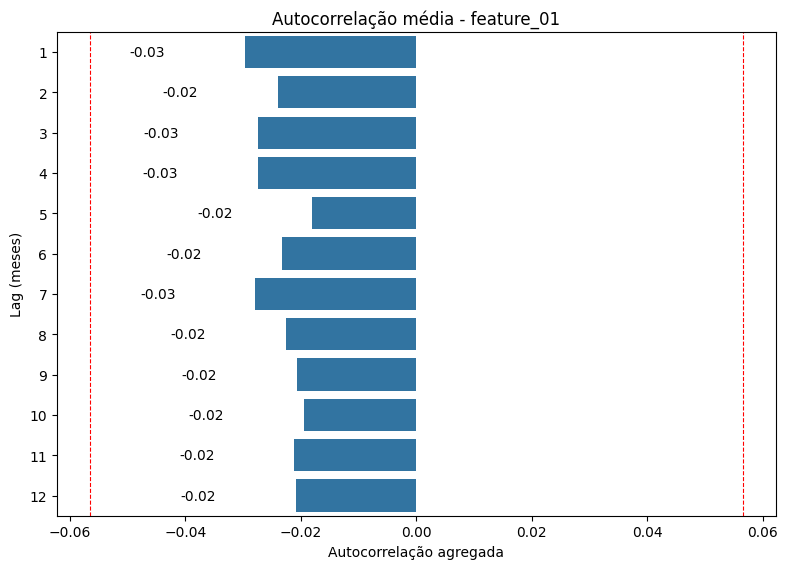

In [9]:
# Plotar gráfico da ACF média entre contratos
vs.plot_panel_acf(panel_acf, title="Autocorrelação média - feature_01")

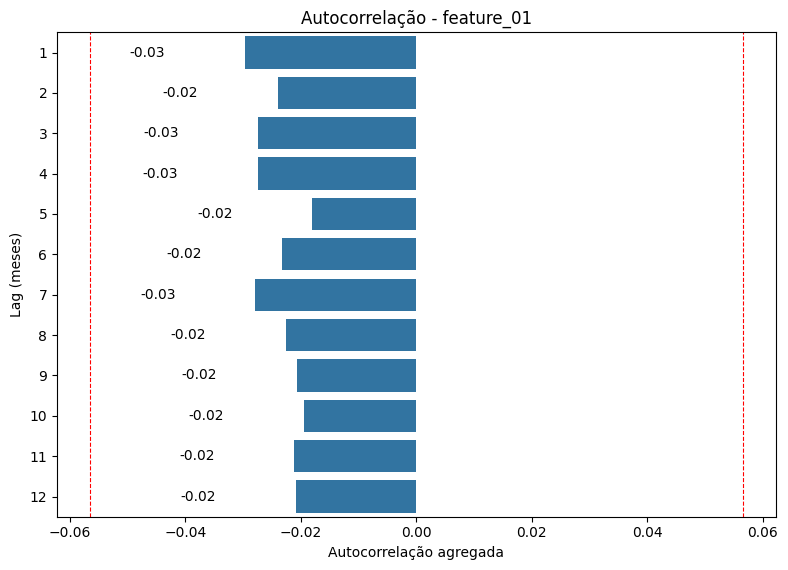

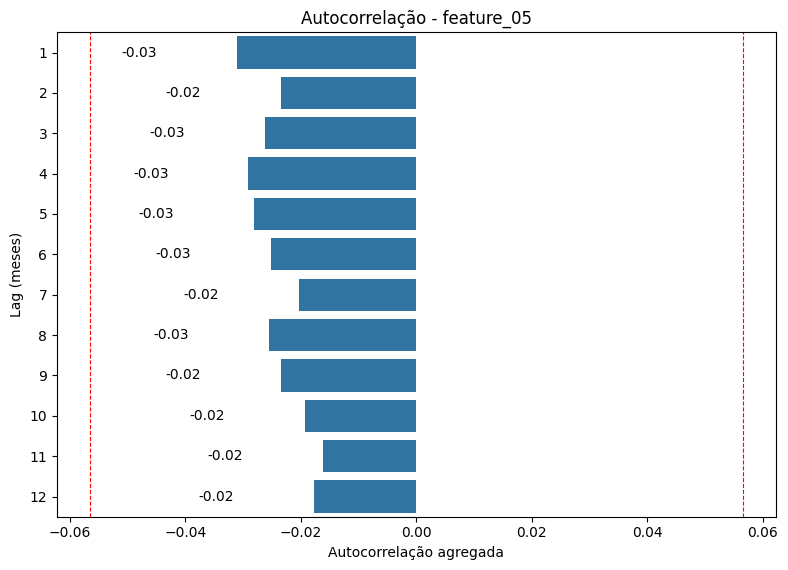

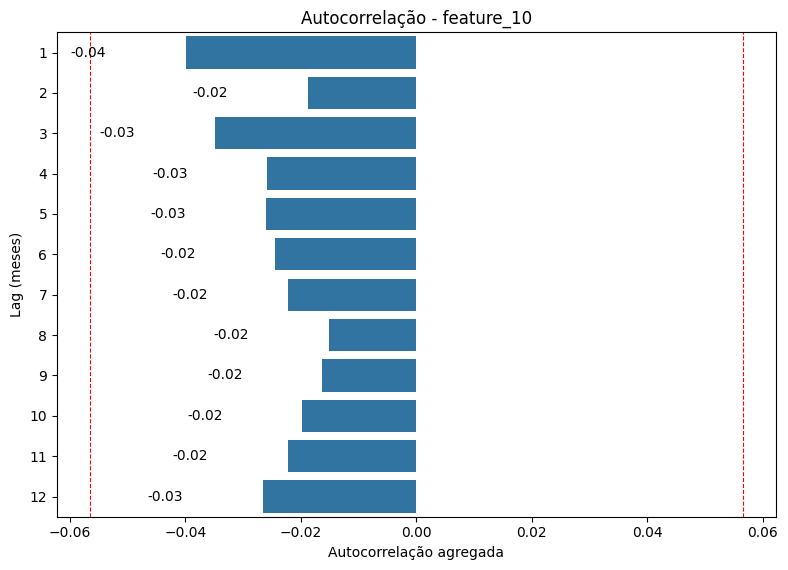

In [10]:
for col in ["feature_01", "feature_05", "feature_10"]:
    acf_df = vs.compute_panel_acf(
        df,
        value_col=col,
        time_col="AnoMesReferencia",
        id_col="NroContrato",
        nlags=12,
        agg_method="mean",
        min_periods=12,
        verbose=False
    )
    vs.plot_panel_acf(acf_df, title=f"Autocorrelação - {col}")
